# Download Import 

In [1]:
# !pip install Flask==2.0.3
# !pip install requests==2.27.1
# !pip install scikit-learn==1.0.2
# !pip install numpy==1.21.5
# !pip install tqdm==4.63.0
# !pip install torch==1.9.0
# !pip install rich==12.0.0


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.2 MB/s 
     |████████████████████████████████| 6.6 MB 50.9 MB/s 
     |████████████████████████████████| 120 kB 48.1 MB/s 


In [3]:
import transformers
print(transformers.__version__)

4.21.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/SapienzaNLP/nlp2022-hw2.git

Mounted at /content/drive
Cloning into 'nlp2022-hw2'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 49 (delta 21), reused 42 (delta 15), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [5]:
import json
import random
import numpy as np
import torch
import os
from typing import List
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from tqdm import tqdm

torch.cuda.is_available()

True

In [6]:
project_path = '/content/drive/MyDrive/Colab Notebooks/NLP HW2'
en_train_path = os.path.join(project_path, 'data_hw2', 'EN', 'train.json')
en_dev_path = os.path.join(project_path, 'data_hw2', 'EN', 'dev.json')

In [7]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## BERT params




In [8]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from transformers import AlbertTokenizerFast, AlbertForTokenClassification
from transformers import AutoModelForTokenClassification

In [9]:
# https://huggingface.co/transformers/v3.3.1/pretrained_models.html
# https://huggingface.co/docs/transformers/model_doc/bert

# checkpoint = "bert-base-cased" #bert-base-uncased
checkpoint ="albert-base-v1"
max_length = 32

tokenizer = AlbertTokenizerFast.from_pretrained(checkpoint, add_prefix_space=True)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [10]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)


# Dataset

In [11]:
# Taken from utils.read_dataset
def read_dataset(path: str):
    with open(path) as f:
        dataset = json.load(f)

    sentences, labels = {}, {}
    for sentence_id, sentence in dataset.items():
        sentence_id = sentence_id
        sentences[sentence_id] = {
            "words": sentence["words"],
            "lemmas": sentence["lemmas"],
            "pos_tags": sentence["pos_tags"],
            "dependency_heads": [int(head) for head in sentence["dependency_heads"]],
            "dependency_relations": sentence["dependency_relations"],
            "predicates": sentence["predicates"],
        }

        labels[sentence_id] = {
            "predicates": sentence["predicates"],
            "roles": {int(p): r for p, r in sentence["roles"].items()}
            if "roles" in sentence
            else dict(),
        }
        
    return sentences, labels

In [12]:
# Reading trainig data to ensure that we will have all the tags
sentences, labels = read_dataset(en_train_path)

role_tags = set()
for sent_id in labels:
  roles = list(labels[sent_id]['roles'].values())
  for sent in roles:
    for role in sent:
      role_tags.add(role)
role_tags.add('[PAD]')
tags = list(role_tags)
tags.sort()


# dictionary and id conversion for tags 
id2tag_dict = {i: key for i, key in enumerate(tags)}
tag2id_dict = {key: value for value, key in id2tag_dict.items()}



def tags2ids(labels: List[List]) -> List[List]:
  return [[tag2id_dict[label] for label in label_sent] for label_sent in labels]
def tags2ids_(labels: List) -> List[List]:
  for label in labels:
    if not label in tag2id_dict:
      print(label)
      return []
  return [tag2id_dict[label] for label in labels]

def ids2tags(label_ids: List[List]) -> List[List]:
  return [[id2tag_dict[id] for id in ids] for ids in label_ids]

In [13]:
# from the predicate senses(input to the 34 tasks), receiving predicate positions and predicate words
def get_predicate_tokens(sentence):
  predicates = list(sentence["predicates"])
  predicate_words = []
  predicate_pos = []
  for pos, pred in enumerate(predicates):
    if pred != '_':
      predicate_words.append(sentence['words'][pos])
      predicate_pos.append(pos)
  return predicate_words, predicate_pos

In [26]:
# make align argument classes (as a sentence) for each predicate and convert them into their ids
def get_true_labels_for_classification(roles, n_words) -> List:

  if not type(roles) is dict: #if no predicate, return a list of pad ids
    return [[0]*n_words]

  args_per_predicates = []
  
  for pred in roles.keys():#for each predicate collect arguments' ids
    args_per_predicates.append(tags2ids_(roles[pred]))

  if args_per_predicates==[]:#if no argument for a predicate
    args_per_predicates = [[0]*n_words]
  return args_per_predicates

In [15]:
# Tokenizer function for sentence as a list of words and predicate word together as
# [CLS] sentence [SEP] predicate [SEP]
def tokenize_funct(sentence, predicate_word):
    return tokenizer.encode_plus(text=sentence["words"],text_pair = [predicate_word], is_split_into_words=True, padding = 'max_length', truncation=True, max_length=max_length)

    # return tokenizer.encode_plus(text=sentence["words"],text_pair = [predicate_word], is_split_into_words=True, padding = True, truncation=True)# , max_length=max_length)

In [16]:
# As output of BERT tokenizer might get bigger than original sentence length (play->play, ##ing)
# function aligns each label with their associates tokens

# modified from https://huggingface.co/docs/transformers/tasks/token_classification

def tokenize_and_align_labels(sentence, predicate_word, predicate_pos, label = None):
    tokenized_inputs = tokenize_funct(sentence, predicate_word)
    word_ids = tokenized_inputs.word_ids()  # Map tokens to their respective word.
    previous_word_idx = None
    label_ids = []
    pred_ind = []
    for word_idx in word_ids:  # Set the special tokens to -100.
        if word_idx is None:
            label_ids.append(-100)
            pred_ind.append(0)
        else:
            if word_idx == predicate_pos:
                pred_ind.append(1)
            else:
                pred_ind.append(0)
            if label!=None:
              if word_idx != previous_word_idx:  # Only label the first token of a given word.
                  label_ids.append(label[word_idx])
              else:
                  label_ids.append(-100)
              
        previous_word_idx = word_idx
    if label!=None:
      tokenized_inputs["labels"] = label_ids
    tokenized_inputs["verb_indicator"] = pred_ind
    return tokenized_inputs

In [17]:
# Dataset class
class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, dataset_path: str):
        self.x = []
        self.build(dataset_path)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

    def build(self, dataset_path: str) -> None:
        sentences, labels = read_dataset(dataset_path)
        
        for sentence_id in sentences:
          sentence = sentences[sentence_id]
          label = labels[sentence_id]
          args = get_true_labels_for_classification(label["roles"], len(sentence["words"]))
        
          predicate_words, predicate_pos = get_predicate_tokens(sentence)
          # in case of empty predicate
          if predicate_words == []:
            predicate_words = ['[PAD]']

          for pred, pos, arg in zip(predicate_words, predicate_pos, args):
            
            tokenized_inputs = tokenize_and_align_labels(sentence, pred,pos, arg)
            self.x.append(tokenized_inputs)
            last = self.x[-1]

        print("{} sentences in original".format(len(sentences)))
        print("{} sentences with duplicates". format(len(self.x)))


# Model

In [18]:
# the model architecture is taken from SimpleBERT paper

class ArgClassModule(torch.nn.Module):
    def __init__(self, 
                 hparams,
                 *args, **kwargs) -> None:
        super().__init__()

        self.num_labels = hparams.num_labels
        # layers AutoModel
        self.bert_model = AlbertForTokenClassification.from_pretrained(hparams.language_model_name, output_hidden_states = True )
        # self.bert_model = AutoModel.from_pretrained(hparams.language_model_name, output_hidden_states = True )

        if not hparams.fine_tune_lm:
            for param in self.bert_model.parameters():
                param.requires_grad = False
        self.dropout = torch.nn.Dropout(0.2)

        self.predicate_embedder = torch.nn.Embedding(2, hparams.predicate_emb_dim)
        self.LSTM = torch.nn.LSTM(self.bert_model.config.hidden_size + hparams.predicate_emb_dim, hparams.recurrent_hidden_layer_size, batch_first=True, bidirectional=True)
        
        self.linear1 = torch.nn.Linear(2*hparams.recurrent_hidden_layer_size, hparams.mlp_hidden_size)
        self.linear2 = torch.nn.Linear(hparams.mlp_hidden_size, self.num_labels)
        self.sigmoid = torch.nn.Sigmoid()

        # self.classifier = torch.nn.Linear(
            # self.bert_model.config.hidden_size, hparams.num_labels, bias=False
        # )

    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        labels: torch.Tensor = None,
        verb_indicator: torch.Tensor = None,
        compute_predictions: bool = False,
        compute_loss: bool = True,
        *args,
        **kwargs,
    ) -> torch.Tensor:
        # group model inputs and pass to the model
        model_kwargs = {
          "input_ids": input_ids, 
          "attention_mask": attention_mask
        }
        # not every model supports token_type_ids
        if token_type_ids != None :
          model_kwargs["token_type_ids"] = token_type_ids


        transformers_outputs = self.bert_model(input_ids = input_ids, 
                                               token_type_ids = verb_indicator, 
                                               attention_mask = attention_mask,)
       
        transformers_outputs_sum = self.dropout(transformers_outputs.hidden_states[-1])

        predicate_embedding = self.predicate_embedder(verb_indicator)
        embedded_text_input = torch.cat([self.dropout(transformers_outputs_sum), predicate_embedding], 2)
        batch_size, sequence_length, _ = embedded_text_input.size()
        recurrent_output, (hidden_text, _) = self.LSTM(embedded_text_input)
        recurrent_output = recurrent_output.view(batch_size, sequence_length, 2, hidden_text.shape[-1])
        fwd_output = recurrent_output[:, :, 0, :]
        back_output = recurrent_output[:, :, 1, :]
        recurrent_combined = torch.cat((fwd_output, back_output), 2)
        lin1 = self.linear1(recurrent_combined)
        logits = self.linear2(self.sigmoid(lin1))
        # logits = self.classifier(transformers_outputs_sum)
        output = {"logits": logits}
        
        if compute_predictions:
            predictions = logits.argmax(dim=-1)
            output["predictions"] = predictions

        if compute_loss and labels is not None:
            output["loss"] = self.compute_loss(logits, labels)

        return output

    def compute_loss(
        self, logits: torch.Tensor, labels: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute the loss of the model.
        Args:
            logits (`torch.Tensor`):
                The logits of the model.
            labels (`torch.Tensor`):
                The labels of the model.
        Returns:
            obj:`torch.Tensor`: The loss of the model.
        """
        return F.cross_entropy(
            logits.view(-1, self.num_labels),
            labels.view(-1),
            ignore_index=-100,
        )



In [19]:
project_folder = '/content/nlp2022-hw2'
state_dict_path = os.path.join( project_folder, 'model' )

## Evaluate and predict func

In [20]:
# Taken from evaluate.py
def evaluate_argument_identification(labels, predictions, null_tag="_"):
    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold = labels[sentence_id]["roles"]
        pred = predictions[sentence_id]["roles"]
        predicate_indices = set(gold.keys()).union(pred.keys())
        for idx in predicate_indices:
            if idx in gold and idx not in pred:
                false_negatives += sum(1 for role in gold[idx] if role != null_tag)
            elif idx in pred and idx not in gold:
                false_positives += sum(1 for role in pred[idx] if role != null_tag)
            else:  # idx in both gold and pred
                for r_g, r_p in zip(gold[idx], pred[idx]):
                    if r_g != null_tag and r_p != null_tag:
                        true_positives += 1
                    elif r_g != null_tag and r_p == null_tag:
                        false_negatives += 1
                    elif r_g == null_tag and r_p != null_tag:
                        false_positives += 1
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [21]:

def predict(model_to_predict, weights_path, sentences, device):

  model_to_predict.load_state_dict(torch.load(weights_path, map_location=torch.device(device)))
  sentences_pbar = tqdm(enumerate(sentences), total=len(sentences))
  
  predictions = {}
  for i, sentence_id in sentences_pbar:
    roles = {}
    sentence = sentences[sentence_id]
    x = []
  
    predicate_words, predicate_pos = get_predicate_tokens(sentence)
    # in case of empty predicate
    if predicate_words==[]:
      predicate_words = ['[PAD]']

    for pred, pos in zip(predicate_words, predicate_pos):
      tokenized_inputs = tokenize_and_align_labels(sentence, pred, pos)
      x.append(tokenized_inputs)
      batch = {k: torch.unsqueeze(torch.tensor(v), 0).to(device) for k, v in tokenized_inputs.items()}
      
      Y_hat = model_to_predict.forward(**batch, compute_predictions = True)
      output = torch.squeeze(Y_hat['predictions'],0)
      tags_per_sent =  ids2tags([[ (tag_dist).item() for tag_dist in output]])[0]

      lab = postprocess(tags_per_sent, tokenized_inputs.word_ids())
      roles[pos]=lab
      
     
    predictions[sentence_id] = {"roles": roles}
  return predictions

In [22]:

def evaluate_argument_classification(labels, predictions, null_tag="_"):

    true_positives, false_positives, false_negatives = 0, 0, 0
    for sentence_id in labels:
        gold = labels[sentence_id]["roles"]
        pred = predictions[sentence_id]["roles"]
        predicate_indices = set(gold.keys()).union(pred.keys())

        for idx in predicate_indices:
            if idx in gold and idx not in pred:
                false_negatives += sum(1 for role in gold[idx] if role != null_tag)
            elif idx in pred and idx not in gold:
                false_positives += sum(1 for role in pred[idx] if role != null_tag)
            else:  # idx in both gold and pred
                for r_g, r_p in zip(gold[idx], pred[idx]):
                    if r_g != null_tag and r_p != null_tag:
                        if r_g == r_p:
                            true_positives += 1
                        else:
                            false_positives += 1
                            false_negatives += 1
                    elif r_g != null_tag and r_p == null_tag:
                        false_negatives += 1
                    elif r_g == null_tag and r_p != null_tag:
                        false_positives += 1
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)
    return {
        "true_positives": true_positives,
        "false_positives": false_positives,
        "false_negatives": false_negatives,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [23]:
def postprocess(prediction, word_ids):

    previous_word_idx = None
    label_ids = []

    for i, word_idx in enumerate(word_ids):  # Set the special tokens to -100.
        # print(tokenizer.decode(sentence[i]))
        # if word_idx is None:
            # label_ids.append(-100)
        # print("word ids: {}".format(word_idx))
        if not word_idx is None:
        
            if word_idx != previous_word_idx:  # Only label the first token of a given word.
                # print("word:{}\tword ids: {}\tprev_idx:{}\tprediction:{}".format(tokenizer.decode(sentence[i]),word_idx,previous_word_idx, prediction[i] ))
                label_ids.append(prediction[i])
            # else:
                # label_ids.append(-100)
        previous_word_idx = word_idx
    return label_ids

## Train

In [24]:
def train(device, model: torch.nn.Module, epochs: int, optimizer: torch.optim.Optimizer):
    epoch_loss = list()
    val_epoch_loss = list()

    project_folder = '/content/nlp2022-hw2'
    state_dict_path = os.path.join( project_folder, 'model' )

    early_stopping = True
    early_stopping_mode = 'loss'
    early_stopping_patience = 2
    patience_counter = 0


    number_of_training_steps = len([b for b in train_dataloader])


    for epoch in range(epochs):  # loop over the dataset multiple times
      batch_pbar = tqdm(enumerate(train_dataloader), total=number_of_training_steps)
      losses = []
      for i, batch in batch_pbar:
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        # move batch data to the specified device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # ** operator converts batch items in named arguments, (e.g. 'input_ids', 'attention_mask_ids' ...), taken as input by the model forward pass
        outputs = model(**batch)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        batch_pbar.set_postfix({'loss': loss.item()})
        losses.append(loss.item())
      epoch_loss.append(torch.mean(torch.tensor(losses)))
      print('loss {:.3f} \n'.format( epoch_loss[-1]))
      torch.save(model.state_dict(),
             os.path.join(state_dict_path, 'state_{}.pt'.format(epoch)))


      number_of_validation_steps = len([b for b in dev_dataloader])
      eval_pbar = tqdm(enumerate(dev_dataloader), total=number_of_validation_steps)
      val_losses = []
      for i, batch in eval_pbar:
          with torch.no_grad():
              batch = {k: v.to(device) for k, v in batch.items()}
              # ** operator converts batch items in named arguments, (e.g. 'input_ids', 'attention_mask_ids' ...), taken as input by the model forward pass
              outputs = model(**batch, compute_predictions = True)
              val_loss = outputs["loss"]
              batch_pbar.set_postfix({'loss': loss.item()})
              val_losses.append(val_loss.item())
      val_epoch_loss.append(torch.mean(torch.tensor(val_losses)))
      print('val loss {:.3f} \n'.format( val_epoch_loss[-1]))
      # to  stop training before overfitting
      if early_stopping:
          # choose metric to monitor
          stop = early_stopping_mode == 'loss' and epoch > 0 and val_epoch_loss[-1] >= val_epoch_loss[-2]
          # set patience
          if stop:
              if patience_counter >= early_stopping_patience:
                  # print('Early stop.')
                  break
              else:
                  patience_counter += 1
                  print(f'-- Patience {patience_counter} out of {early_stopping_patience}.\n')
    return epoch_loss, val_epoch_loss

# eXperiment

In [28]:
train_dataset = Dataset(en_train_path)
dev_dataset = Dataset(en_dev_path)

5501 sentences in original
12562 sentences with duplicates
1026 sentences in original
2553 sentences with duplicates


In [37]:
batch_size = 8

num_workers = 2
# optim
learning_rate = 1e-4
weight_decay = 0.0
transformer_learning_rate = 5e-5
transformer_weight_decay = 0.0001
# training
epochs = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
dev_dataloader = DataLoader(
    dev_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [31]:
checkpoint

'albert-base-v1'

## Model def

In [32]:

class HyperParams():

    language_model_name = checkpoint
    num_labels = 28
    recurrent_hidden_layer_size = 768
    mlp_hidden_size = 300
    predicate_emb_dim = 10
    fine_tune_lm = True

    batch_size = 8
    max_length = 32

hparams = HyperParams()

In [33]:
# model = ArgClassModule(checkpoint, len(tag2id_dict.keys()),recurrent_hidden_layer_size=768, mlp_hidden_size=300,  fine_tune_lm = True)
model = ArgClassModule(hparams)

model.to(device)


Some weights of the model checkpoint at albert-base-v1 were not used when initializing AlbertForTokenClassification: ['predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at albert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably

ArgClassModule(
  (bert_model): AlbertForTokenClassification(
    (albert): AlbertModel(
      (embeddings): AlbertEmbeddings(
        (word_embeddings): Embedding(30000, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): AlbertTransformer(
        (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
        (albert_layer_groups): ModuleList(
          (0): AlbertLayerGroup(
            (albert_layers): ModuleList(
              (0): AlbertLayer(
                (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (attention): AlbertAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)

In [34]:
from torch.optim import Adam

# optimizer
groups = [
  {
    "params": model.linear1.parameters(),
    "lr": learning_rate,
    "weight_decay": weight_decay,
  },
  {
    "params": model.linear2.parameters(),
    "lr": learning_rate,
    "weight_decay": weight_decay,
  },
  # {
  #   "params": model.classifier.parameters(),
  #   "lr": learning_rate,
  #   "weight_decay": weight_decay,
  # },
  {
    "params": model.bert_model.parameters(),
    "lr": transformer_learning_rate,
    "weight_decay": transformer_weight_decay,
  },
]
optimizer = Adam(groups)

In [35]:
torch.cuda.empty_cache()

## Run Train

In [38]:
epoch_loss, val_epoch_loss = train(device, model, epochs = epochs, optimizer = optimizer)

100%|██████████| 1571/1571 [01:18<00:00, 20.14it/s, loss=0.129]


loss 0.297 



100%|██████████| 320/320 [00:04<00:00, 68.18it/s]

val loss 0.160 



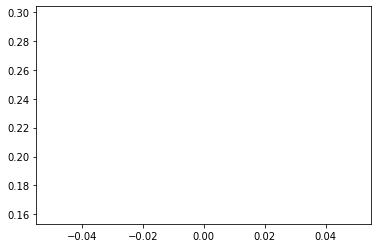

In [39]:
plt.plot(np.array(epoch_loss), 'r', np.array(val_epoch_loss), 'b')

## Predict

In [40]:
sentences, labels = read_dataset(en_dev_path)
state_path = os.path.join(state_dict_path, 'state_0.pt')
predictions = predict(model, state_path, sentences, device)

100%|██████████| 1026/1026 [00:30<00:00, 33.56it/s]


In [41]:
evaluate_argument_identification(labels, predictions, null_tag="_")


{'true_positives': 3488,
 'false_positives': 505,
 'false_negatives': 716,
 'precision': 0.8735286751815677,
 'recall': 0.829686013320647,
 'f1': 0.8510430645358057}

In [48]:
evaluate_argument_classification(labels, predictions, null_tag="_")

{'true_positives': 2074,
 'false_positives': 1919,
 'false_negatives': 2130,
 'precision': 0.5194089656899574,
 'recall': 0.4933396764985728,
 'f1': 0.5060387946809809}